In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.io import loadmat

import fmEphys as fme

Loading DLC 2.2.3...


In [2]:
celldata = loadmat(r'D:\dendritic_img\230606_MJG_MJG044_DendriticImaging_GC6s\TSeries-06062023-1410-Soma-NatMov-002_registered_data.mat')

In [30]:
celldata['data'][1:]

array([], shape=(0, 1),
      dtype=[('filename', 'O'), ('numFrames', 'O'), ('xPixels', 'O'), ('yPixels', 'O'), ('map_type', 'O'), ('frameRate', 'O'), ('avg_projection', 'O'), ('frame_F', 'O'), ('activity_map', 'O'), ('cellMasks', 'O'), ('raw_F', 'O'), ('normtype', 'O'), ('DFF_raw', 'O'), ('DFF', 'O')])

In [28]:
celldata['data']['DFF'][0][0].shape

(7, 10680)

In [31]:
stimmat = loadmat(r'C:\Users\dmartins\Desktop\TouchofEvil.mat')

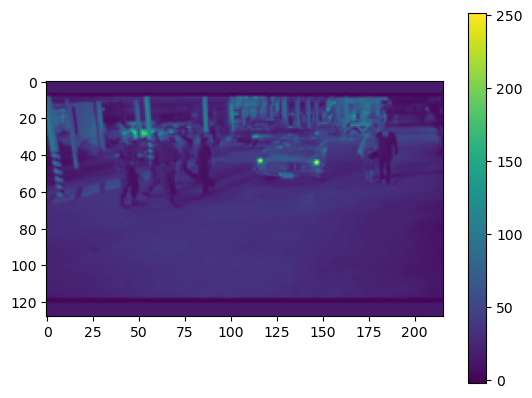

In [48]:
plt.imshow(stimmat['TouchofEvil'][:,:,0])
plt.colorbar()

In [49]:
full_stim = stimmat['TouchofEvil'].copy()

In [ ]:
celldata['data']['DFF'][0][0]

In [46]:
30*30

900

In [56]:
dFF = celldata['data']['DFF'][0][0]

In [129]:
stim = np.ones(
    [np.size(full_stim,0),
    np.size(full_stim,1),
    int(np.ceil(np.size(dFF,1) * 3))] # 2P is @ 10 Hz, stim is @ 30 Hz
) * (255*0.5)

In [58]:
stim.shape

(128, 216, 32040)

In [130]:
loop_len = int(30*30)
isi_len = int(30*5)

_s = int(30*2)
for rep in range(30):
    
    stim[:,:,_s:_s+loop_len] = full_stim[:,:,:900].copy()
    _s += 900

    _s += isi_len

In [131]:
twopT = np.arange(0, np.size(dFF,1)*0.1, 0.1)
stimT = np.arange(0, np.size(stim,2)*(1/30), 1/30)

In [70]:
from scipy.interpolate import interp1d
def interpT(x, xT, toT):
    """ Interpolate timestamps.
    
    Parameters
    ----------
    x : np.array
        Array of values to interpolate.
    xT : np.array
        Array of datetime objects corresponding to x.
    toT : np.array
        Array of datetime objects to interpolate to.

    Returns
    -------
    out : np.array
        Array of interpolated values.

    """

    # Convert timestamps to float values.

    out = interp1d(xT, x,
                   bounds_error=False)(toT)
    
    return out

In [72]:
interpDFF = interpT(dFF, twopT, stimT)

In [117]:
_usestim = stim.copy()
_usestim = np.moveaxis(_usestim, 2, 1)

nks = np.size(stim[:,:,0])

all_sta = np.zeros([np.size(interpDFF,0),
                    np.size(stim, 0),
                    np.size(stim, 1)])


In [118]:
lag = 2

for c in range(np.size(interpDFF,0)):

    # normalize
    _d = interpDFF[c,:].copy()
    _d -= np.min(_d)
    _d /= np.max(_d)

    sp = _d.copy()
    sp = np.roll(sp, -lag)
    sta = _usestim.T @ sp
    sta = np.reshape(sta, nks)
    nsp = np.sum(sp)

    # if nsp > 0:
    sta = sta / nsp
    sta = sta - np.mean(sta)

    all_sta[c,:,:] = sta

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 32040 is different from 128)

In [135]:
np.size(stim,0)

128

In [134]:
np.size(stim,1) * np.size(stim,2)

6920640

In [146]:
np.size(stim,0) * np.size(stim,1)

27648

(array([1.2557e+04, 8.0880e+03, 3.1040e+03, 1.9360e+03, 9.9100e+02,
        4.4400e+02, 3.0300e+02, 1.8600e+02, 2.9000e+01, 1.0000e+01]),
 array([ -1.56469424,  20.3738374 ,  42.31236903,  64.25090067,
         86.1894323 , 108.12796394, 130.06649557, 152.00502721,
        173.94355885, 195.88209048, 217.82062212]),
 <BarContainer object of 10 artists>)

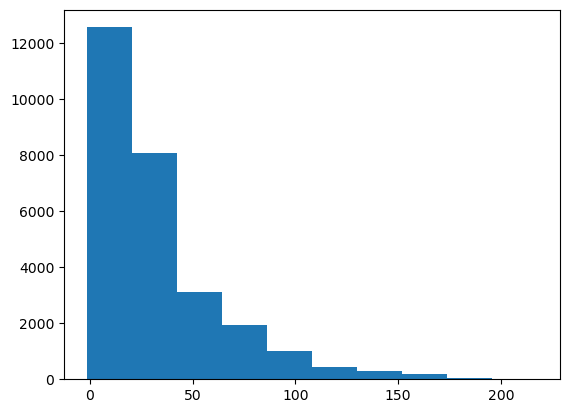

In [155]:
plt.hist(stim[:,:,100].flatten())

In [174]:
from tqdm import tqdm

In [165]:
stim.shape

(128, 216, 32040)

In [169]:
import gazecontrol as gc

In [177]:

def calc_sta(stim, dFF, lag=2):

    _usestim = np.zeros([np.size(stim,2),
                        (np.size(stim,0) * np.size(stim,1))],
                        dtype=np.uint8)
    
    for f in range(np.size(stim,2)):
        _usestim[f,:] = stim[:,:,f].copy().flatten().astype(np.uint8)
    
    nks = np.shape(stim[:,:,0])

    all_sta = np.zeros([np.size(dFF, 0),
                        np.size(stim, 0),
                        np.size(stim, 1)])

    for c in tqdm(range(np.size(dFF,0))):

        # normalize
        sp = dFF[c,:].copy()
        # sp = gc.norm(_d)

        # sp = np.roll(sp, -lag)
        sta = _usestim.T @ sp
        sta = np.reshape(sta, nks)
        nsp = np.nansum(sp)

        # if nsp > 0:
        sta = sta / nsp
        sta = sta - np.nanmean(sta)

        all_sta[c,:,:] = sta

    return all_sta

In [183]:
_usestim = np.zeros([np.size(stim,2),
                    (np.size(stim,0) * np.size(stim,1))],
                    dtype=np.uint8)

for f in range(np.size(stim,2)):
    _usestim[f,:] = stim[:,:,f].copy().flatten().astype(np.uint8)

nks = np.shape(stim[:,:,0])

all_sta = np.zeros([np.size(dFF, 0),
                    np.size(stim, 0),
                    np.size(stim, 1)])


In [200]:
np.shape(sp)

(32040,)

In [228]:

for c in tqdm(range(np.size(interpDFF,0))):

    # normalize
    _d = interpDFF[c,:].copy()
    sp = gc.norm(_d)

    mask = ~np.isnan(sp)
    sta = _usestim.T[:,mask] @ sp[mask]
    sta = np.reshape(sta, nks)
    nsp = np.nansum(sp)

    # if nsp > 0:
    sta = sta / nsp
    sta = sta - np.nanmean(sta)

    all_sta[c,:,:] = sta

100%|██████████| 7/7 [01:12<00:00, 10.43s/it]


In [234]:
np.max(all_sta)

56.55627145212519

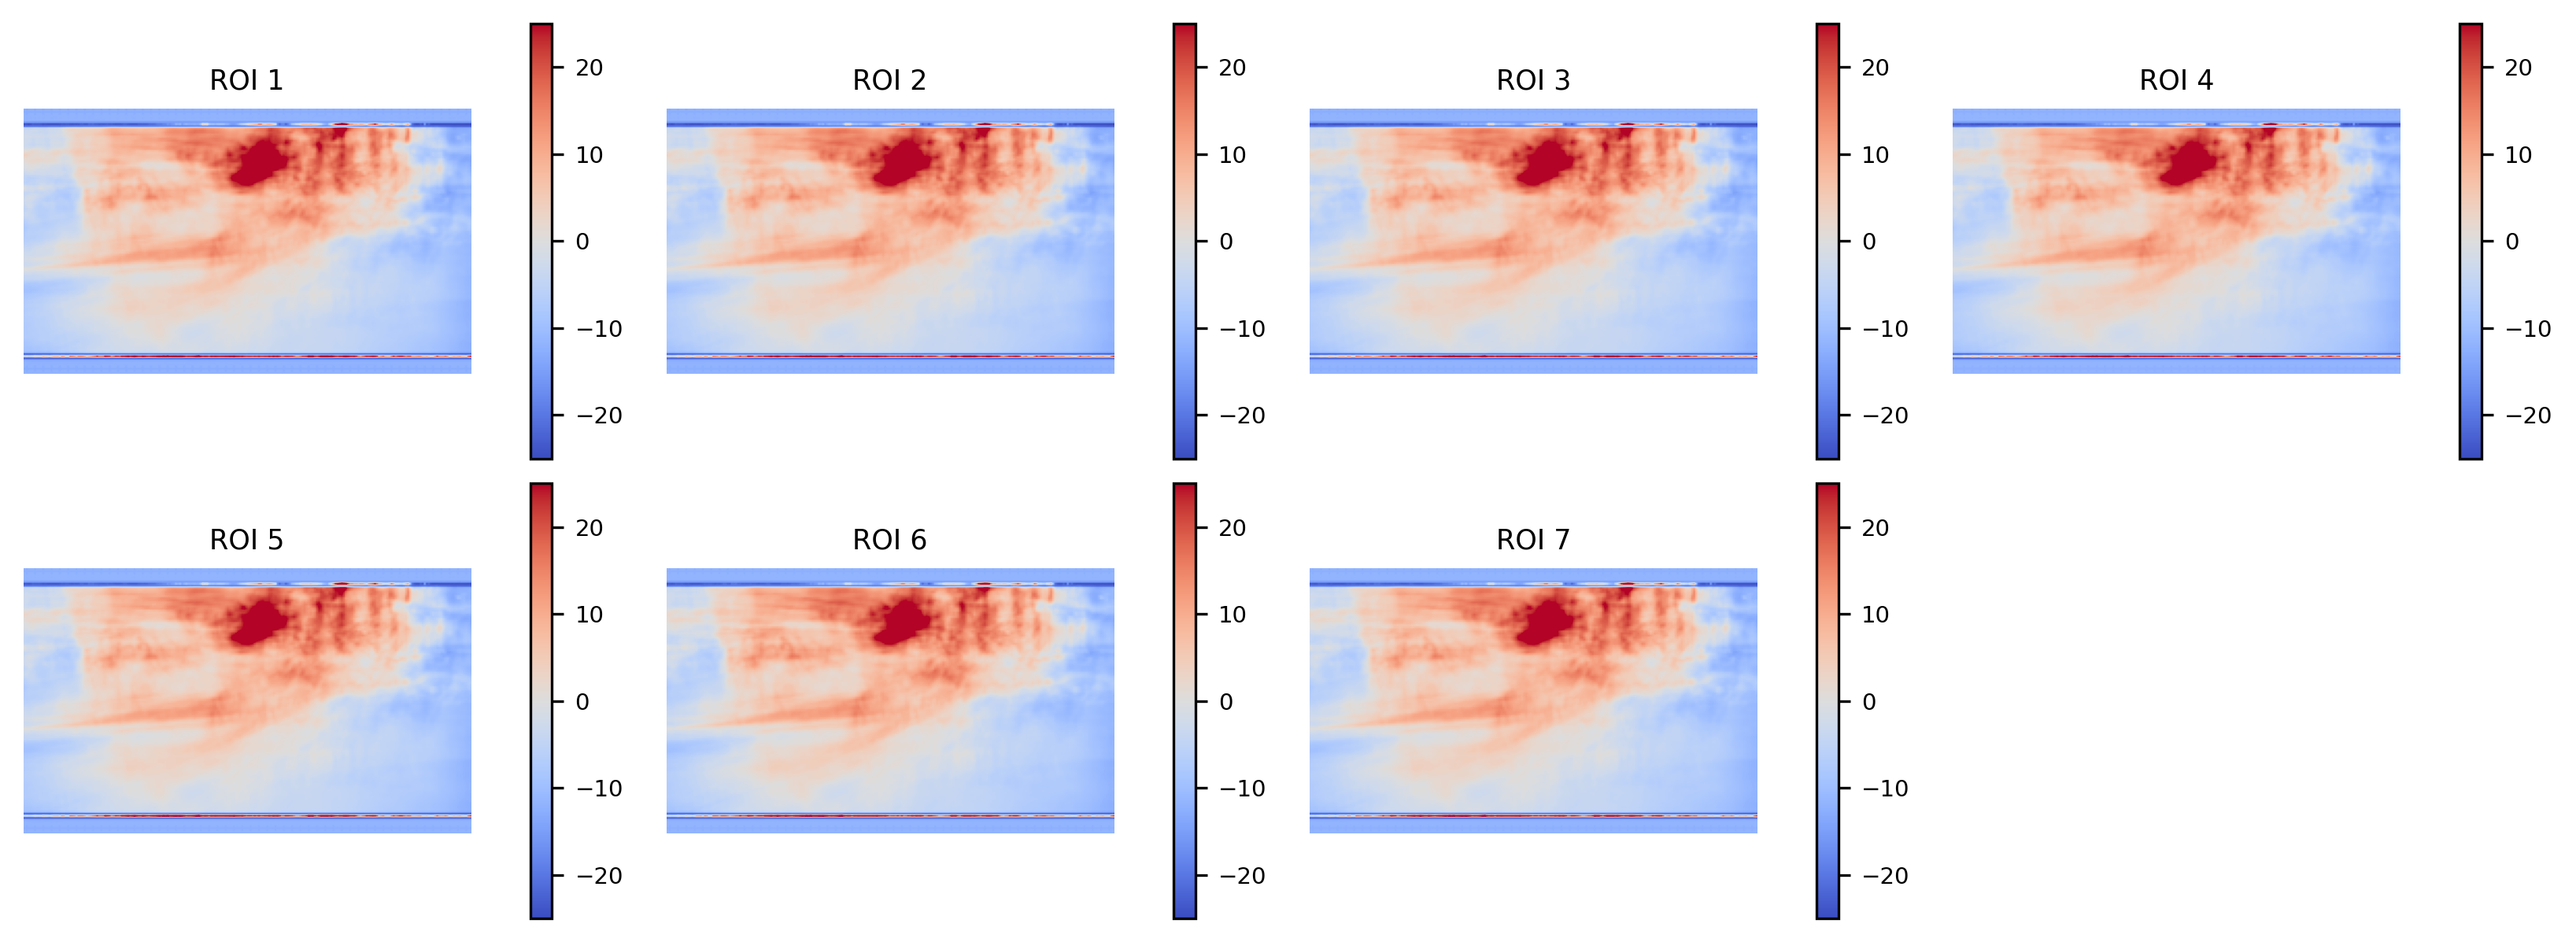

In [240]:
fig, axs = plt.subplots(2,4, figsize=(11,4), dpi=300)
axs = axs.flatten()

for c in range(np.size(all_sta,0)):

    _tmp_im = axs[c].imshow(all_sta[c,:,:], cmap='coolwarm',
                            vmin=-25, vmax=25)
    plt.colorbar(_tmp_im, ax=axs[c], pad=0.1)
    axs[c].set_title('ROI {}'.format(c+1))
    axs[c].axis('off')

axs[c+1].axis('off')

fig.tight_layout()

Text(0.5, 25.166666666666647, 'ROI #')

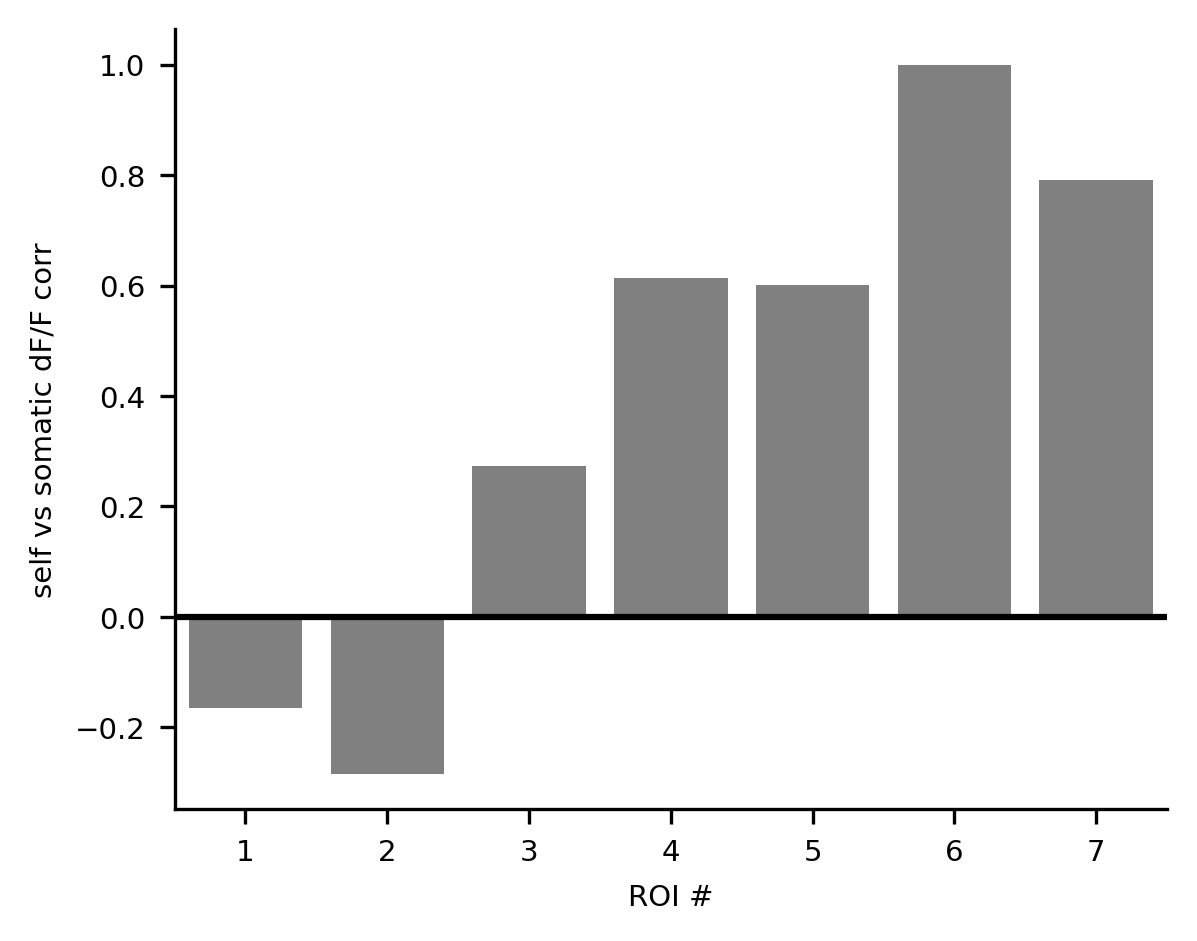

In [279]:
_corr_vals = np.zeros(7)
for n in range(7):
    mask = ~(np.isnan(interpDFF[n,:]) * np.isnan(interpDFF[5,:]))
    _corr_arr = np.corrcoef(interpDFF[n,mask], interpDFF[5,mask])
    _corr_vals[n] = _corr_arr[0,1]

fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=300)
ax.bar(np.arange(7), _corr_vals, color='grey')
ax.hlines(0, -1, 8, color='k')
ax.set_ylabel('self vs somatic dF/F corr')
fig.tight_layout()
ax.set_xlim(-0.5, 6.5)
ax.set_xticks(np.arange(7), labels=np.arange(1,8).astype(int))
ax.set_xlabel('ROI #')